In [9]:
# -*- coding: utf-8 -*-
"""
H&M Environmental Claim Consistency — final logic version

- Claims: extracted from brand reports (long sentence, with domain).
- Certifications: extracted from brand reports, checked against whitelist.
- Violations: extracted from lawsuit texts, using keyword matching.
- SAFE if claim has at least one allowed certification; otherwise check domain-matched violations.
- Graph edges:
    Brand -> Claim (MAKES)
    Claim -> Cert (COMPLIES_WITH)
    Brand -> Violation (VIOLATES)
    Claim -> Violation (VIOLATES, only if domain matches)
"""

import re
import networkx as nx

# 0) INPUT SOURCES
brand_sources = ["/content/HM_sustainability_report_2024.txt"]
external_sources = ["/content/lawsuit.txt"]

# 1) LOAD FILES
source_texts = {}
for path in brand_sources + external_sources:
    with open(path, "r", encoding="utf-8") as f:
        source_texts[path] = f.read()

# 2) PREPROCESS
def preprocess_text(text: str) -> str:
    text = re.sub(r'\bPage \d+\b|www\.hmgroup\.com', ' ', text, flags=re.I)
    text = text.replace("\u00ad", "")
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

cleaned_brand_texts = {p: preprocess_text(source_texts[p]) for p in brand_sources}
cleaned_external_texts = {p: preprocess_text(source_texts[p]) for p in external_sources}

# 3) CONFIG
CLAIM_DOMAIN_RX = {
    "climate": re.compile(r'(net[-\s]?zero|greenhouse\s+gas|ghg|scope\s*1\s*&?\s*2|scope\s*3|decarbon|carbon)\b', re.I),
    "renewable_energy": re.compile(r'\brenewable\s+(?:electricity|energy)\b', re.I),
    "chemicals_water": re.compile(r'\b(zdhc|mrsl|wastewater|effluent|etp|chemical|water)\b', re.I),
    "wood_forest": re.compile(r'\b(FSC|PEFC|wood|forest|cellulosic|MMCF)\b', re.I),
    "materials_textile": re.compile(r'\b(material|textile|cotton|polyester|recycled|sustainably\s+sourced|Textile\s+Exchange|GOTS|RWS|RMS|GCS)\b', re.I),
    "circularity": re.compile(r'\b(circular|zero\s*waste|reuse|repair|recycling|close[-\s]*loop)\b', re.I),
}
VIOLATION_DOMAIN_RX = CLAIM_DOMAIN_RX

CERT_WHITELIST = {
    "climate": {"SBTI"},
    "renewable_energy": {"RE100"},
    "chemicals_water": {"ZDHC", "MRSL"},
    "wood_forest": {"FSC", "PEFC"},
    "materials_textile": {"GOTS", "RWS", "RMS", "GCS", "TEXTILE EXCHANGE"},
    "circularity": set(),
}
CERT_TOKENS = [
    r'\bSBTI\b', r'\bRE100\b', r'\bZDHC\b', r'\bMRSL\b',
    r'\bFSC\b', r'\bPEFC\b', r'\bGOTS\b', r'\bRWS\b',
    r'\bRMS\b', r'\bGCS\b', r'Textile\s+Exchange'
]
violation_keywords = [
    'misleading', 'false', 'untrue', 'removed', 'scrutiny',
    'lawsuit', 'alleging', 'investigation', 'high emissions',
    'failure to meet', 'being sued', 'misrepresentation'
]

# 4) EXTRACTION
def split_sentences(text: str):
    return re.split(r'(?<=[\.\!\?])\s+', text)

def classify_claim_domain(sentence: str):
    for dom, rx in CLAIM_DOMAIN_RX.items():
        if rx.search(sentence):
            return dom
    return None

def classify_violation_domain(sentence: str):
    for dom, rx in VIOLATION_DOMAIN_RX.items():
        if rx.search(sentence):
            return dom
    return None

def extract_claims(text: str):
    out = []
    for s in split_sentences(text):
        sent = s.strip()
        if not sent:
            continue
        dom = classify_claim_domain(sent)
        if dom:
            out.append((sent, dom))
    return out

def extract_certs(text: str):
    found = set()
    for pat in CERT_TOKENS:
        for m in re.finditer(pat, text, flags=re.I):
            tok = m.group(0)
            if re.search(r'Textile\s+Exchange', tok, re.I):
                found.add("TEXTILE EXCHANGE")
            else:
                found.add(tok.upper())
    return found

def extract_violations(text: str):
    out, seen = [], set()
    for s in split_sentences(text):
        sent = s.strip()
        if not sent:
            continue
        if any(re.search(r'\b' + re.escape(kw) + r'\b', sent, re.I) for kw in violation_keywords):
            if sent.lower() not in seen:
                seen.add(sent.lower())
                out.append(sent)
    return out

# Run extraction
brand_entities, external_entities = {}, {}
all_claims, all_certs, all_violations = [], set(), []
for src, txt in cleaned_brand_texts.items():
    claims, certs = extract_claims(txt), extract_certs(txt)
    brand_entities[src] = {"claims": claims, "certs": certs}
    all_claims += [(c[0], c[1], src) for c in claims]
    all_certs |= certs
for src, txt in cleaned_external_texts.items():
    violations = extract_violations(txt)
    external_entities[src] = violations
    all_violations += [(v, src) for v in violations]

print("=== Extracted Entities ===")
print("Claims:", len(all_claims))
print("Certifications:", sorted(all_certs))
print("Violations:", len(all_violations))
for i, (v, s) in enumerate(all_violations, 1):
    print(f"  Violation_{i}: {v} (src={s})")

# 5) BUILD KG
G = nx.DiGraph()
G.add_node("H&M", type="Brand")
for src in brand_sources + external_sources:
    G.add_node(src, type="Source")

claim_nodes = {}
for i, (sent, dom, src) in enumerate(all_claims, 1):
    cid = f"Claim_{i}"
    claim_nodes[cid] = {"text": sent, "domain": dom, "src": src}
    G.add_node(cid, type="Claim", description=sent, domain=dom)
    G.add_edge("H&M", cid, relation="MAKES")
    G.add_edge(cid, src, relation="APPEARS_IN")

whitelist_universe = set().union(*CERT_WHITELIST.values())
for c in sorted(all_certs):
    if c in whitelist_universe:
        G.add_node(c, type="Certification")

for cid, info in claim_nodes.items():
    dom, src = info["domain"], info["src"]
    allowed = CERT_WHITELIST.get(dom, set())
    for c in (brand_entities[src]["certs"] & allowed):
        G.add_edge(cid, c, relation="COMPLIES_WITH")

violation_nodes = {}
for i, (vtext, src) in enumerate(all_violations, 1):
    vid = f"Violation_{i}"
    violation_nodes[vid] = {"text": vtext, "src": src}
    G.add_node(vid, type="Violation", description=vtext)
    G.add_edge("H&M", vid, relation="VIOLATES")
    G.add_edge(vid, src, relation="APPEARS_IN")

for cid, cinfo in claim_nodes.items():
    cdom = cinfo["domain"]
    for vid, vinfo in violation_nodes.items():
        vdom = classify_violation_domain(vinfo["text"])
        if vdom == cdom:
            G.add_edge(cid, vid, relation="VIOLATES")

print("\nKG Stats: Nodes =", G.number_of_nodes(), "Edges =", G.number_of_edges())

# 6) CONSISTENCY REPORT
def detect_inconsistencies(G, lawsuit_sources):
    paths, score, report = [], 0, []
    vio_sources = {v: [t for _, t, ed in G.out_edges(v, data=True) if ed.get("relation")=="APPEARS_IN"]
                   for v,d in G.nodes(data=True) if d.get("type")=="Violation"}
    for cid, cdata in [(n,d) for n,d in G.nodes(data=True) if d.get("type")=="Claim"]:
        claim_text, domain = cdata["description"], cdata["domain"]
        allowed_certs = sorted(list(CERT_WHITELIST.get(domain, set())))
        evidence_certs = [
            tgt for _,tgt,ed in G.out_edges(cid, data=True)
            if ed["relation"]=="COMPLIES_WITH" and tgt in allowed_certs
        ]
        safe = len(evidence_certs)>0
        vios = [v for _,v,ed in G.out_edges(cid, data=True) if ed["relation"]=="VIOLATES"]
        inconsistent = (not safe) and len(vios)>0
        if inconsistent:
            score += 1
            paths.append(["Brand::H&M", cid, vios[0]])
        report.append({
            "claim_node": cid,
            "claim_text": claim_text,
            "domain": domain,
            "allowed_certs": allowed_certs,
            "evidence_certs": evidence_certs,
            "safe": safe,
            "inconsistent": inconsistent,
            "violations": [{
                "violation_node": v,
                "violation_snippet": G.nodes[v]["description"][:200],
                "sources": vio_sources.get(v, [])
            } for v in vios],
            "paths": [["Brand::H&M", cid, v] for v in vios]
        })
    return paths, score, report

paths, score, report = detect_inconsistencies(G, external_sources)

print("\n=== CONSISTENCY REPORT ===")
for r in report:
    print(f"\nCLAIM NODE: {r['claim_node']}")
    print(f"  Domain          : {r['domain']}")
    print(f"  Claim (full)    : {r['claim_text']}")
    print(f"  Allowed certs   : {r['allowed_certs']}")
    print(f"  Evidence certs  : {r['evidence_certs']}")
    print(f"  SAFE?           : {r['safe']}")
    print(f"  INCONSISTENT?   : {r['inconsistent']}")
    if r["violations"]:
        print("  Violations (from lawsuit):")
        for v in r["violations"]:
            print(f"    - {v['violation_node']} | {v['violation_snippet']}...")
            print(f"      Sources: {v['sources']}")
    if (not r["safe"]) and r["paths"]:  # only show in detail if not safe
        print("  Paths:")
        for p in r["paths"]:
            print(f"    - {' -> '.join(p)}")

print("\nDetected Inconsistency Paths:")
for r in report:
    if (not r["safe"]) and r["inconsistent"]:  # exclude SAFE claims
        for p in r["paths"]:
            print(" -> ".join(p))
print("Inconsistency Score:", score)


=== Extracted Entities ===
Claims: 239
Certifications: ['FSC', 'MRSL', 'RE100', 'RWS', 'SBTI', 'TEXTILE EXCHANGE', 'ZDHC']
Violations: 12
  Violation_1: H&M is Being Sued For “Misleading” Sustainability Marketing. (src=/content/lawsuit.txt)
  Violation_2: Images: H&M H&M is being sued for '“false” and “misleading” sustainability marketing. (src=/content/lawsuit.txt)
  Violation_3: In a class-action lawsuit filed on July 22nd, Plaintiff Chelsea Commodore, a New York state resident, alleges that despite its position as a fast-fashion giant, H&M is deceptively capitalizing on the growing segment of conscious consumers by creating an extensive marketing scheme to greenwash its products and present them as environmentally friendly when they are not. (src=/content/lawsuit.txt)
  Violation_4: Commodore alleges that among other things, H&M's sustainability labeling, marketing, and advertising is “designed to mislead consumers through the use of false environmental sustainability profiles. (src

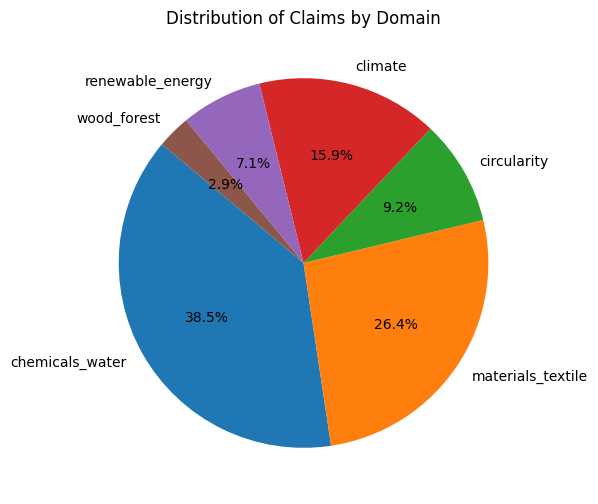

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

# Count total claims per domain
domain_counts = Counter([r['domain'] for r in report])

# Count inconsistent claims per domain
inconsistent_counts = Counter([r['domain'] for r in report if r['inconsistent']])

# ----- Pie Chart 1: Distribution of claims per domain -----
labels1 = list(domain_counts.keys())
sizes1 = [domain_counts[d] for d in labels1]

plt.figure(figsize=(6,6))
plt.pie(sizes1, labels=labels1, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Claims by Domain")
plt.show()


In [4]:
# 8) KG NODE and EDGE COMPOSITION

from collections import Counter

print("\n=== KG NODE and EDGE COMPOSITION ===")

# Node composition
node_types = [data.get("type") for _, data in G.nodes(data=True)]
node_counts = Counter(node_types)

print(f"Total Nodes: {G.number_of_nodes()}")
for t, c in node_counts.items():
    print(f"  {t:15s}: {c}")

# Edge composition
edge_types = [data.get("relation") for _, _, data in G.edges(data=True)]
edge_counts = Counter(edge_types)

print(f"\nTotal Edges: {G.number_of_edges()}")
for rel, c in edge_counts.items():
    print(f"  {rel:15s}: {c}")



=== KG NODE and EDGE COMPOSITION ===
Total Nodes: 261
  Brand          : 1
  Source         : 2
  Claim          : 239
  Certification  : 7
  Violation      : 12

Total Edges: 918
  MAKES          : 239
  VIOLATES       : 56
  APPEARS_IN     : 251
  COMPLIES_WITH  : 372
